em算法原理介绍[从最大似然到 EM 算法浅解](http://blog.csdn.net/zouxy09/article/details/8537620)

其应用主要在数据聚类领域(data clustering)

参考文章:[Intro to Expectation-Maximization, K-Means, Gaussian Mixture Models with Python, Sklearn](http://www.blackarbs.com/blog/intro-to-expectation-maximization-k-means-gaussian-mixture-models-with-python-sklearn/3/20/2017)

In [1]:
import time

import pandas as pd
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## EM算法原理
>EM is an iterative process that begins with a "naive" or random initialization and then alternates between the expectation and maximization steps until the algorithm reaches convergence.

下面是一个具体的例子

In [2]:
# import class heights
f = 'https://raw.githubusercontent.com/BlackArbsCEO/Mixture_Models/K-Means%2C-E-M%2C-Mixture-Models/Class_heights.csv'

data = pd.read_csv(f)
height = data['Height (in)']

In [3]:
data

,Gender,Height (in)
0,Male,72
1,Male,72
2,Female,63
3,Female,62
4,Female,62
5,Male,73
6,Female,64
7,Female,63
8,Female,67
9,Male,71


现在假设如果我们没有Gender这一列，那问题就变为我们如何从观测到的身高这一列，我们怎么能推测出性别，此时性别就是我们要估计的隐变量

我们再来正式的描述下问题：

- 此处我们的身高 x 来自于两个均值< μ1, μ2 >的分布，
- 身高 x 是我们观测变量
- 隐变量性别是EM算法要预估出来的
- 每个x都有两个相关联的变量< z1, z2 >

此处关于 z1 和 z2 的取值对于我们理解EM算法非常有帮助

在 K-means 算法中，z的取值只有0或者1，这种分类称为 hard clustering，而在Gaussian Mixture Models模型中，z的值是0-1之间的一个数，可能的值是z1=0.85,z2=0.15,代表的含义是x很有可能来自于分类1，这种分类方法称为 soft or fuzzy clustering

在具体的实施上，EM算法分为两步，expectation step 和 maximization step，以Gaussian Mixture Models为例：

**The expectation step**
 
We calculate the expected values $E(z_{ij})$, which is the probability that $x_i$ was drawn from the $jth$ distribution.
     
$$E(z_{ij}) = \frac{p(x = x_i|\mu = \mu_j)}{\sum_{n=1}^2 p(x = x_i|\mu = \mu_j)}$$
 
 
$$= \frac{ e^{-\frac{1}{2\sigma^2}(x_i - \mu_j)^2} }
{ \sum_{n=1}^2e^{-\frac{1}{2\sigma^2}(x_i - \mu_n)^2} }$$

**The maximization step**
After calculating all $E(z_{ij})$ values we can calculate (update) new $\mu$ values. 

$$ \mu_j = \frac {\sum_{i=1}^mE(z_{ij})x_i} {\sum_{i=1}^mE(z_{ij})}$$

接着我们来实现下这个EM算法
## simple EM GaussianMixture

In [4]:
np.random.seed(0)
mu1_fact = (0, 0, 0)
cov_fact = np.identity(3)
data1 = np.random.multivariate_normal(mu1_fact, cov_fact, 400)
mu2_fact = (2, 2, 1)
cov_fact = np.identity(3)
data2 = np.random.multivariate_normal(mu2_fact, cov_fact, 100)
data = np.vstack((data1, data2))
y = np.array([True] * 400 + [False] * 100)

In [5]:
print(data1.shape,data2.shape,data.shape)

(400, 3) (100, 3) (500, 3)


In [6]:
from sklearn.mixture import GaussianMixture
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

In [7]:
g = GaussianMixture(n_components=2, covariance_type='full', tol=1e-6, max_iter=1000)
g.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=1e-06, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [23]:
print('类别概率:\t', g.weights_[0]) # 4/5
print('均值:\n', g.means_, '\n') #[[0,0,0],[2,2,1]]
print('方差:\n', g.covariances_, '\n') # 对角1矩阵

类别概率:	 0.744104025837
均值:
 [[-0.07255166 -0.06875491 -0.12428664]
 [ 1.74652944  1.76401045  0.92998549]] 

方差:
 [[[ 0.85645342 -0.09625984 -0.02439478]
  [-0.09625984  1.01121453 -0.09640856]
  [-0.02439478 -0.09640856  0.85564497]]

 [[ 1.1279412   0.04945608 -0.00666527]
  [ 0.04945608  1.14114602  0.06399139]
  [-0.00666527  0.06399139  0.8886593 ]]] 



## simple EM freehand
下面的代码来自小象的机器学习算法

In [9]:
np.random.seed(0)
mu1_fact = (0, 0, 0)
cov_fact = np.identity(3)
data1 = np.random.multivariate_normal(mu1_fact, cov_fact, 400)
mu2_fact = (2, 2, 1)
cov_fact = np.identity(3)
data2 = np.random.multivariate_normal(mu2_fact, cov_fact, 100)
data = np.vstack((data1, data2))
y = np.array([True] * 400 + [False] * 100)

In [10]:
from scipy.stats import multivariate_normal
num_iter = 100
n, d = data.shape # 500, 3
mu1 = data.min(axis=0) #每列最小
mu2 = data.max(axis=0)
sigma1 = np.identity(d) # 协矩阵
sigma2 = np.identity(d) 
pi = 0.5 # 先验概率

In [11]:
for i in range(num_iter):
    # E Step
    norm1 = multivariate_normal(mu1, sigma1)
    norm2 = multivariate_normal(mu2, sigma2)
    tau1 = pi * norm1.pdf(data)
    tau2 = (1 - pi) * norm2.pdf(data)
    gamma = tau1 / (tau1 + tau2)

    # M Step
    mu1 = np.dot(gamma, data) / np.sum(gamma)
    mu2 = np.dot((1 - gamma), data) / np.sum((1 - gamma))
    sigma1 = np.dot(gamma * (data - mu1).T, data - mu1) / np.sum(gamma)
    sigma2 = np.dot((1 - gamma) * (data - mu2).T, data - mu2) / np.sum(1 - gamma)
    pi = np.sum(gamma) / n
    print(i, ":\t", mu1, mu2)

print('类别概率:\t', pi)
print('均值:\t', mu1, mu2)
print('方差:\n', sigma1, '\n\n', sigma2, '\n')

0 :	 [-0.11359772 -0.11177414 -0.15582682] [ 1.750978    1.77295469  0.95334518]
1 :	 [-0.0939775  -0.08867467 -0.1415379 ] [ 1.73674934  1.74955546  0.93765719]
2 :	 [-0.08563433 -0.07998234 -0.13520388] [ 1.73113767  1.74304012  0.93039031]
3 :	 [-0.08160252 -0.07623707 -0.13193519] [ 1.72907607  1.74181727  0.9266361 ]
4 :	 [-0.07948608 -0.07449048 -0.13007819] [ 1.72868927  1.74249895  0.92465788]
5 :	 [-0.07827794 -0.07359204 -0.1289329 ] [ 1.72913547  1.74384222  0.92366889]
6 :	 [-0.0775152  -0.07305603 -0.12816899] [ 1.72999799  1.74536591  0.92326261]
7 :	 [-0.0769756  -0.07267274 -0.1276201 ] [ 1.7310608   1.74688951  0.92321165]
8 :	 [-0.07655    -0.07235237 -0.12719832] [ 1.73220969  1.74835366  0.92338186]
9 :	 [-0.07618418 -0.07205768 -0.12685529] [ 1.73338411  1.74974598  0.92369098]
10 :	 [-0.07585108 -0.07177418 -0.12656335] [ 1.73455232  1.75107047  0.92408711]
11 :	 [-0.07553725 -0.07149693 -0.12630607] [ 1.7356982   1.75233526  0.92453671]
12 :	 [-0.07523601 -0.0712

准确率：91.00%


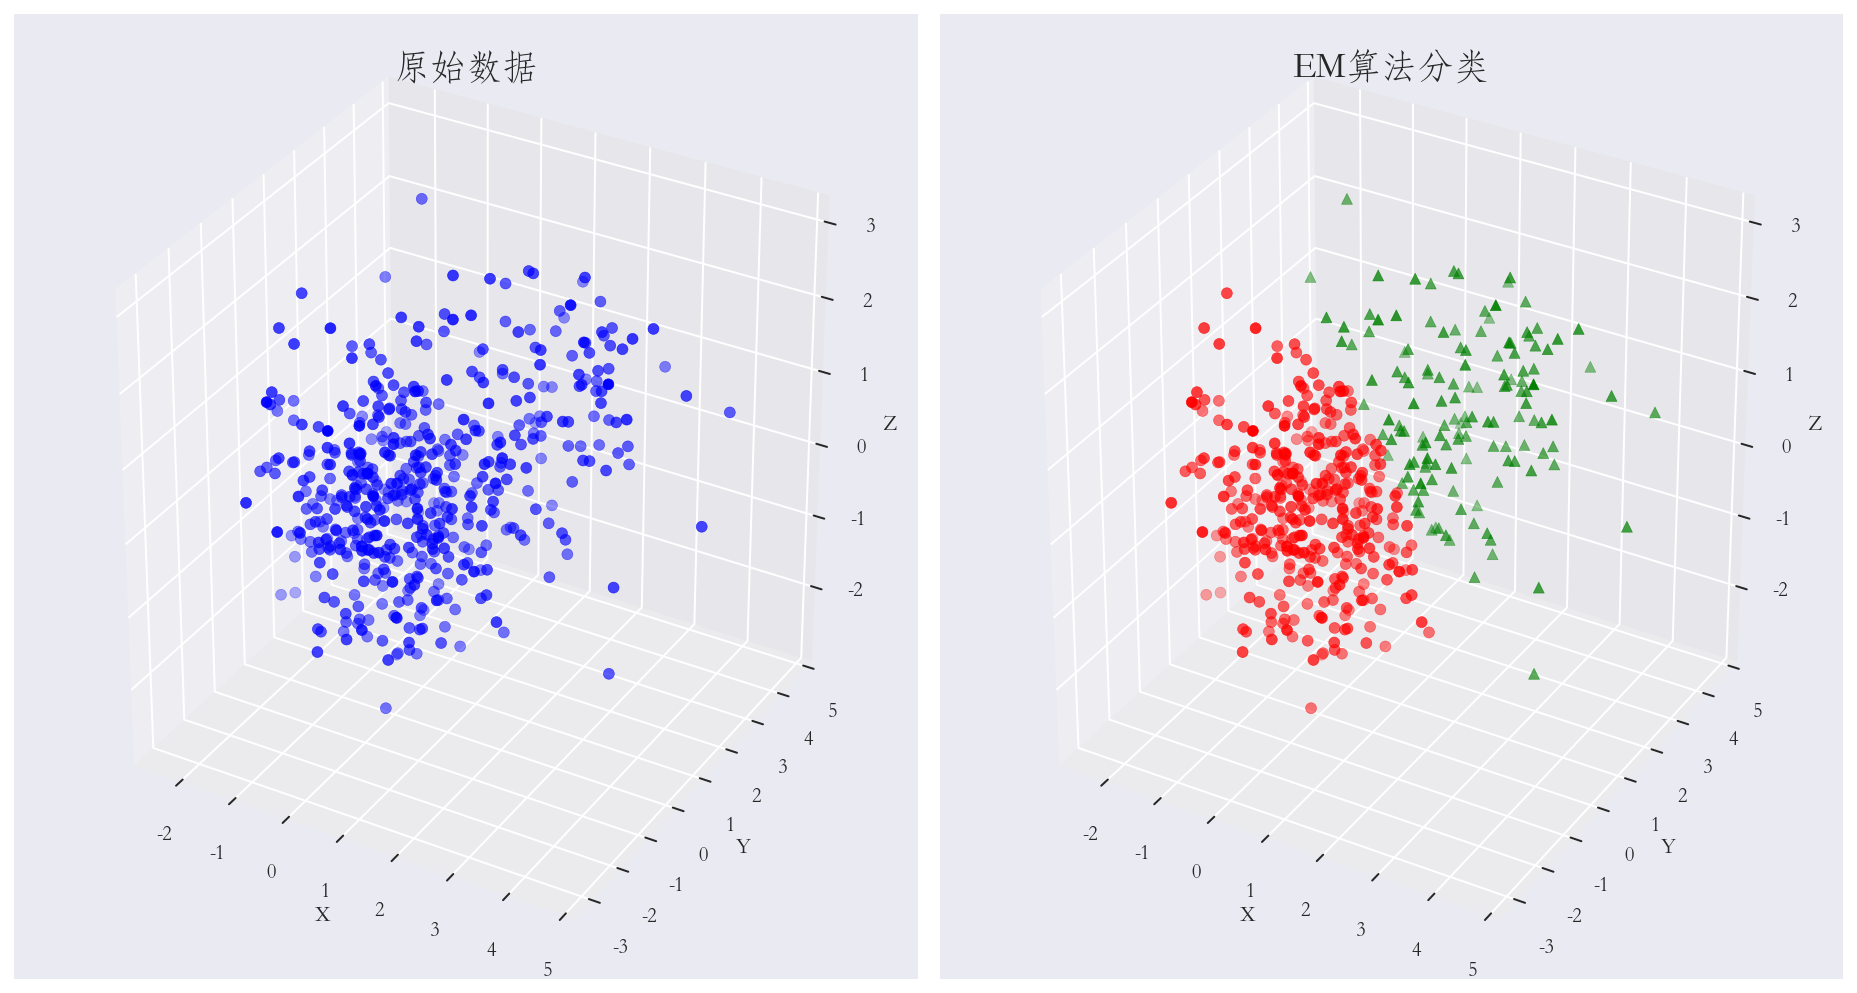

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import pairwise_distances_argmin
import matplotlib as mpl

mpl.rcParams['font.family'] = 'STFangsong'
# mpl.rcParams['font.sans-serif'] = [u'STKaiti']
mpl.rcParams['axes.unicode_minus'] = False
# 预测分类
norm1 = multivariate_normal(mu1, sigma1)
norm2 = multivariate_normal(mu2, sigma2)
tau1 = norm1.pdf(data)
tau2 = norm2.pdf(data)

fig = plt.figure(figsize=(13, 7), facecolor='w')
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=30, marker='o', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(u'原始数据', fontsize=18)
ax = fig.add_subplot(122, projection='3d')
order = pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2], metric='euclidean')
if order[0] == 0:
    c1 = tau1 > tau2
else:
    c1 = tau1 < tau2
c2 = ~c1
acc = np.mean(y == c1)
print(u'准确率：%.2f%%' % (100*acc))
ax.scatter(data[c1, 0], data[c1, 1], data[c1, 2], c='r', s=30, marker='o', depthshade=True)
ax.scatter(data[c2, 0], data[c2, 1], data[c2, 2], c='g', s=30, marker='^', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(u'EM算法分类', fontsize=18)
# plt.suptitle(u'EM算法的实现', fontsize=20)
# plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

##  K-Means 的 EM形式解释
The basic form of K-Means makes two assumptions

1. Each data point is closer to its own cluster center than the other cluster centers
2. A cluster center is the arithmetic mean of all the points that belong to the cluster.

**The expectation step**

计算每个点和假定的中心的距离

**The maximization step** 

重新计算中心点

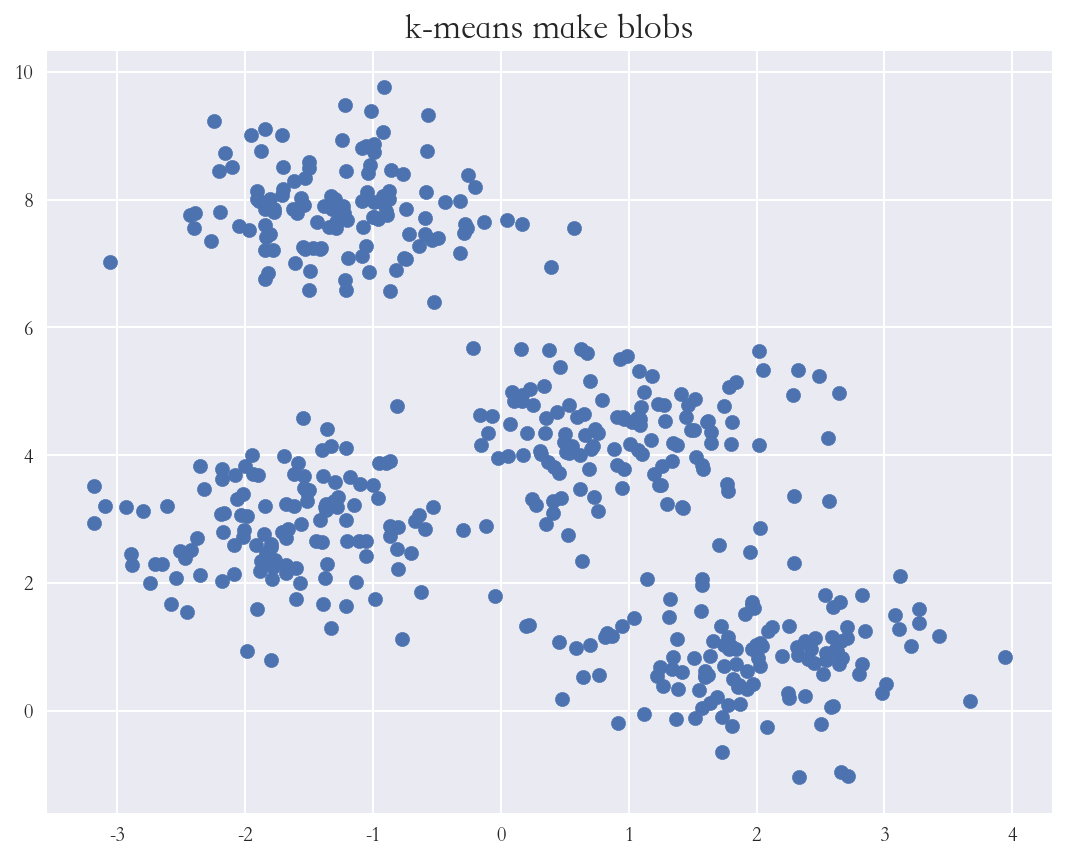

In [24]:
# demo variables

k = 4
n_draws = 500
sigma = .7
random_state = 0
dot_size = 50
cmap = 'viridis'

# make blobs

from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples = n_draws,
                       centers = k,
                       cluster_std = sigma,
                       random_state = random_state)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], s=dot_size)
plt.title('k-means make blobs', fontsize=18, fontweight='demi')

In [25]:
# sample implementation
# code sourced from: 
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

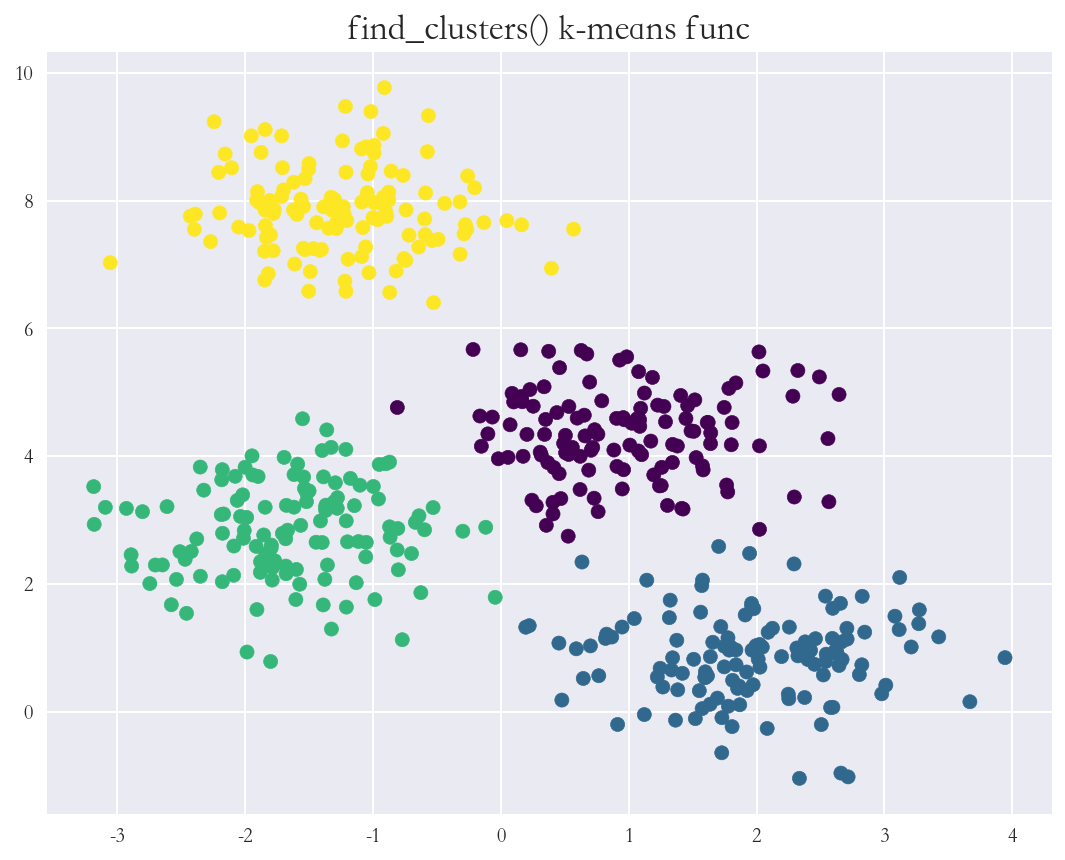

In [26]:
# let's test the implementation

centers, labels = find_clusters(X, k)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap)
plt.title('find_clusters() k-means func', fontsize=18, fontweight='demi')

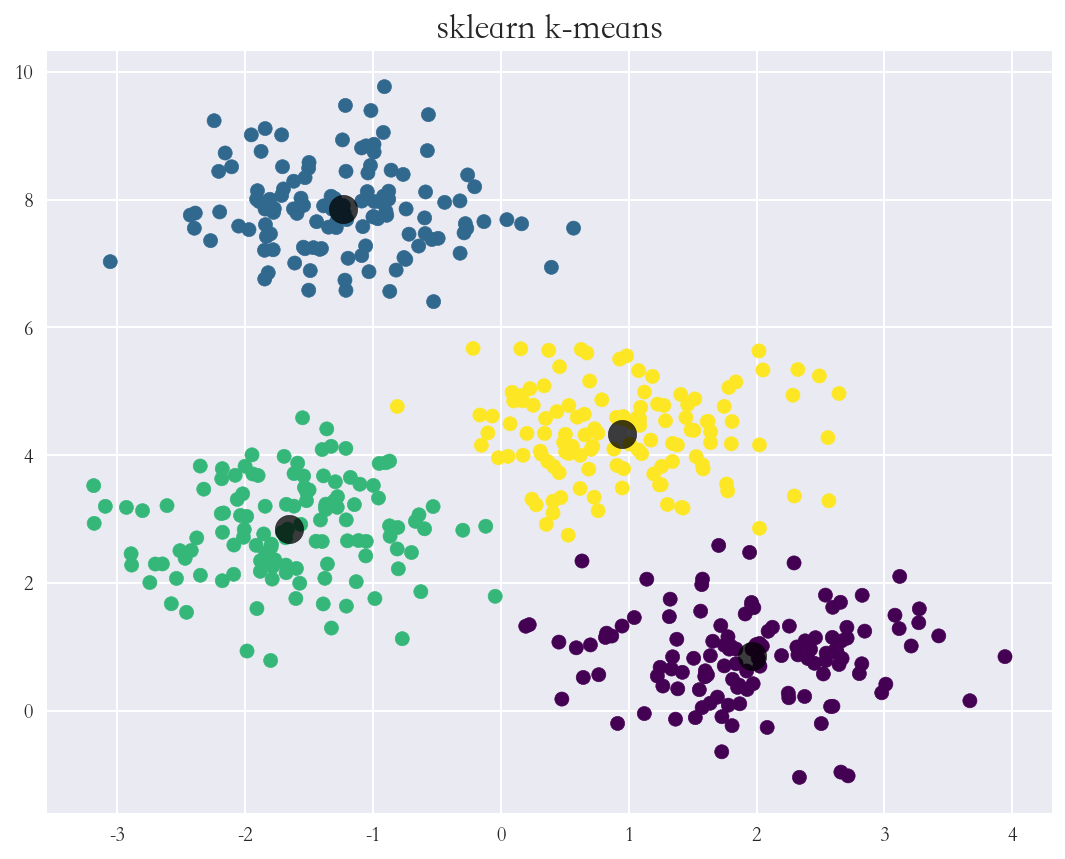

In [27]:
# now let's compare this to the sklearn's KMeans() algorithm

# fit k-means to blobs

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# visualize prediction
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

# get centers for plot
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
plt.title('sklearn k-means', fontsize=18, fontweight='demi')

下面通过一个交互式的代码看下K-Means算法

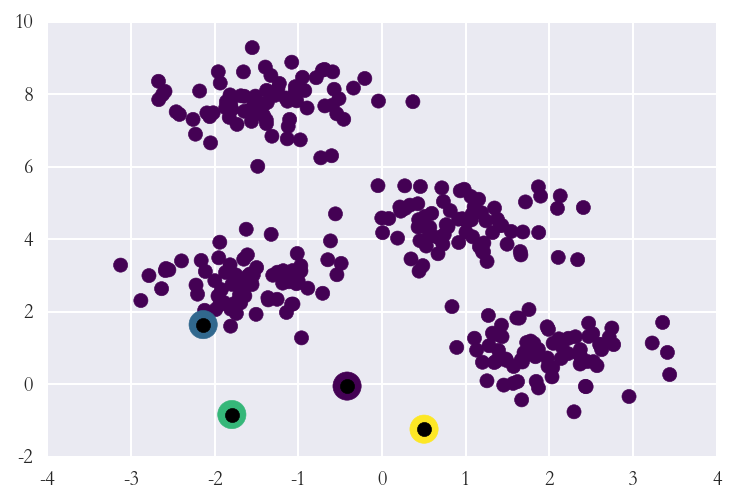

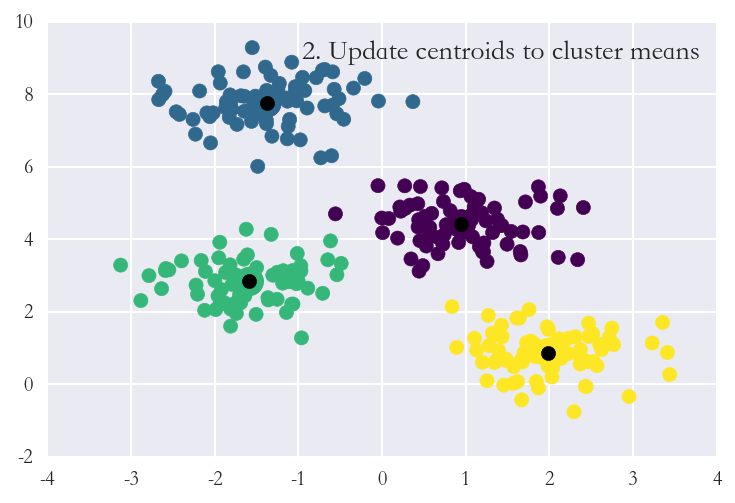

In [32]:
# code sourced from:
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Covariance-Type

from ipywidgets import interact

def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)
        
    def plot_points(X, labels, n_clusters):
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis',
                    vmin=0, vmax=n_clusters - 1);
            
    def plot_centers(centers):
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c=np.arange(centers.shape[0]),
                    s=200, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c='black', s=50)
            

    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        # plot the data and cluster centers
        plot_points(X, labels, n_clusters)
        plot_centers(old_centers)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], 
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plot_centers(centers)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                     ha='right', va='top', size=14)
    
    return interact(_kmeans_step, frame=[0, 50],
                    n_clusters=[min_clusters, max_clusters])

plot_kmeans_interactive(1,4);

## 附录
先来看下多元正态分布怎么回事

In [ ]:
A1 = np.random.multivariate_normal(np.zeros(3), np.eye(3), size=5)
print(A1)

In [ ]:
np.mean(A1,axis=0) # 按列计算均值，和0有差距

In [ ]:
np.cov(A1.T) # 计算协方差。差距也有点大

In [21]:
# mpl.rcParams # 知道参数
# mpl.matplotlib_fname() # 知道配置文件地址
# sorted([f.name for f in mpl.font_manager.fontManager.ttflist]) # 知道至此的字体
# https://www.zhihu.com/question/25404709